In [81]:
import pandas as pd
import time
import numpy as np

# Pandas csv import is faster than python's 'with-open' technique

path_to_train_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\train.csv"
path_to_test_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\test.csv"
train_data = pd.read_csv(path_to_train_data)
test_data = pd.read_csv(path_to_test_data)


In [82]:
def get_cols_with_missing(dfObj, value:"Missing") -> list:
    """Return list of the columns that equal the value."""
    
    listCols = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listCols.append(col)

    unique_cols = np.unique(listCols)
    return unique_cols

# cols_with_missing = get_cols_with_missing(test_data, "Missing")
# print(cols_with_missing)

In [83]:
# Replace missing fields with the mean value of its column
def replace_missing_with_mean(df_object, cols_with_missing:list):
    """Replace the fields in the dataframe object with the mean of that column."""

    df_object.replace(to_replace="Missing", value=np.nan, inplace=True)

    # df_object['OverallQual'].mean() didnt' work because data type not number. Write it up in the report.
    # df_object['OverallQual'].dtypes #dtype('O') is a string

    for col in cols_with_missing:
        df_object[col] = df_object[col].astype('float') # because NaN is a float and mean() requires same data type
        df_object[col].fillna(value=df_object[col].mean(), inplace=True) 
        df_object[col] = df_object[col].astype('int') # linear regression only supports int type

# replace_missing_with_mean(test_data, cols_with_missing)

In [84]:
# Find the columns with 'object' datatypes
def get_categoricals(dataframe) -> list:
    categoricals = []
    for col in dataframe.columns:
        if dataframe[col].dtypes == "object":
            categoricals.append(col)
    return categoricals

# categoricals = get_categoricals(test_data)
# print(categoricals)

In [85]:
# Apply one hot encoding to categoricals.
# Source: https://medium.com/jungletronics/pandas-one-hot-encoding-ohe-eb7467dc92e8

def one_hot_encode(dataframe, categoricals:list):
    """Mutates dataframe by dropping categoricals and concatenating one hot encoding."""

    for idx, category in enumerate(categoricals):
        # print(f'index: {idx} \n')
        variables_list = dataframe[category].unique()
        print(f'category: {category}: {variables_list}')
        if len(variables_list) == 2:
            set_arg = True # set drop_first true because categories are binary
        else:
            set_arg = False

        dummy1 = pd.get_dummies(dataframe[category], drop_first=set_arg)
        dataframe = pd.concat([dataframe, dummy1], axis=1).drop(category, axis=1)
    return dataframe

# test_data = one_hot_encode(test_data, categoricals + ['MSSubClass'])


In [86]:
# Drop columns index and ID because they aren't useful information

# test_data = test_data.drop(['ID'], axis=1)


In [87]:
# Finally, convert all data types to integer for regression model
def convert_dtype_int(df_object):
    for name, data_series in df_object.iteritems():
        df_object[name] = df_object[name].astype(int) # print(scatter_df.dtypes)

# convert_dtype_int(test_data)



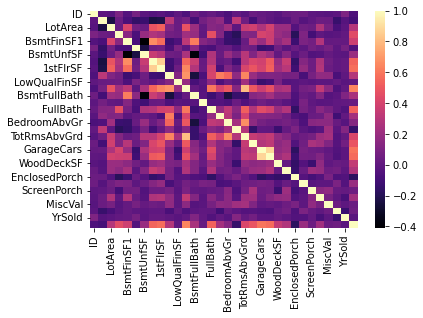

In [88]:
# # Interrogate data

import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization
from termcolor import colored as cl # text customization

sb.heatmap(test_data.corr(), cmap = 'magma')
plt.savefig('heatmap.png', format='png')
plt.show()

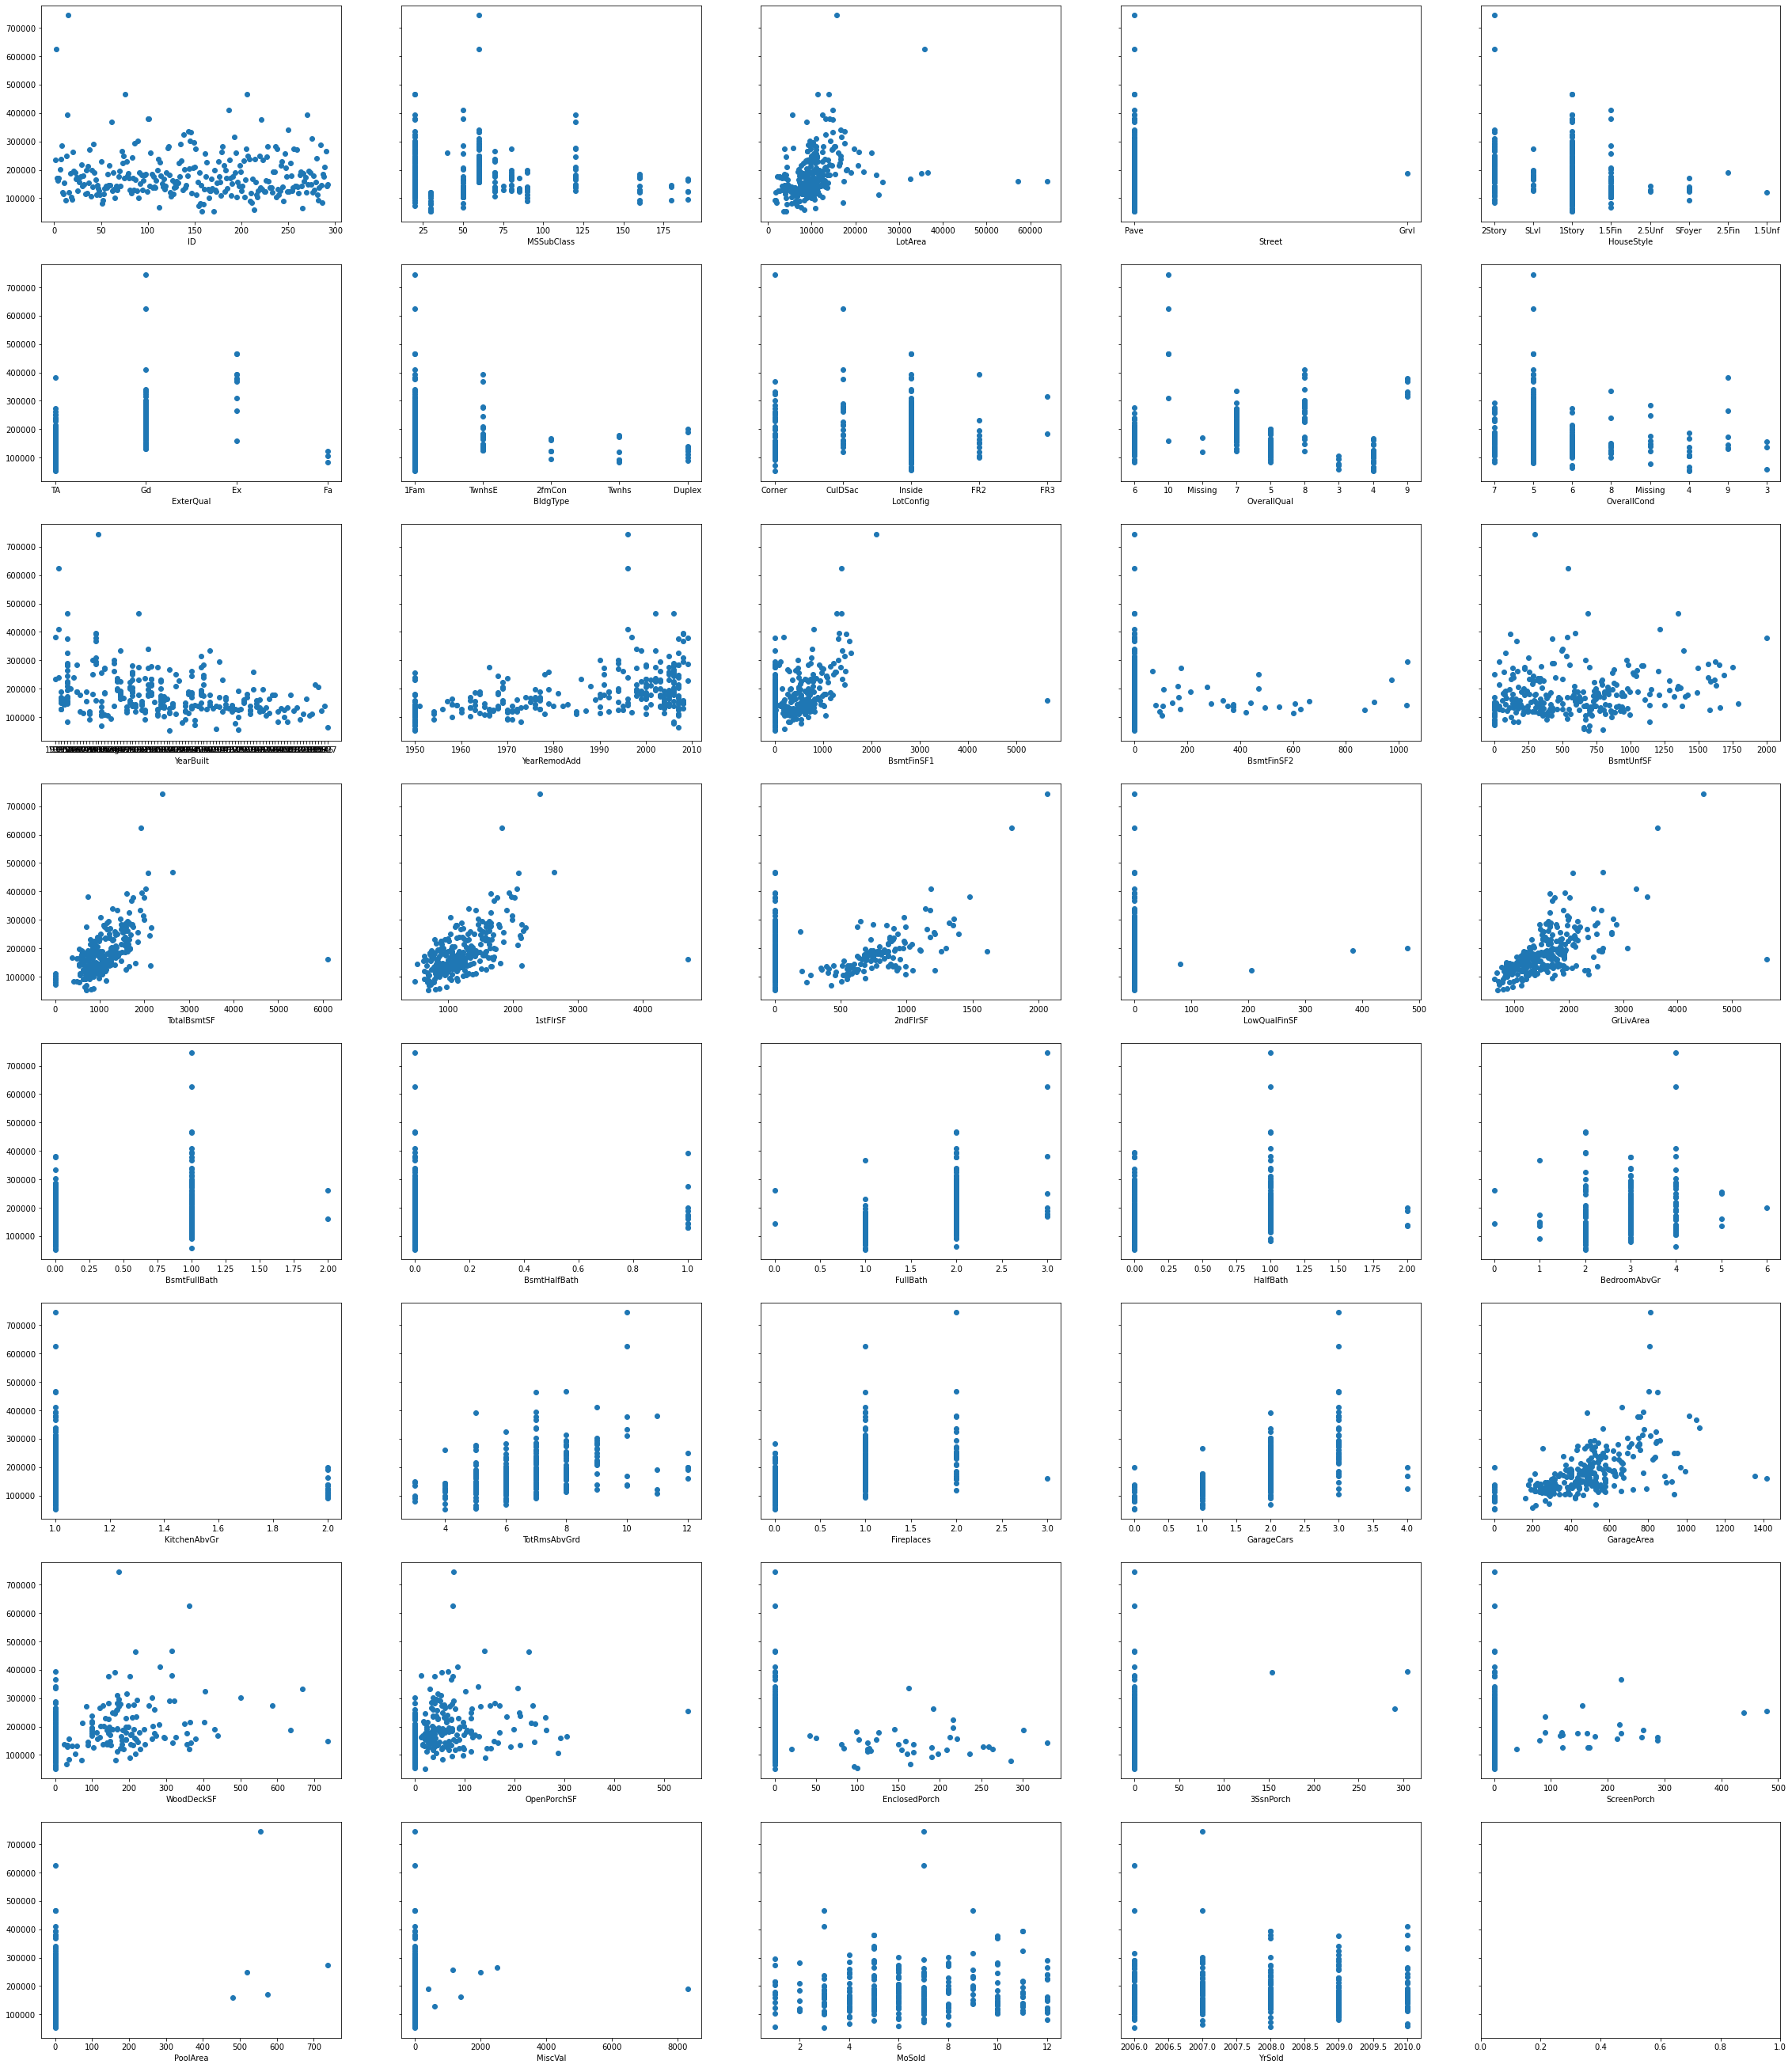

<Figure size 432x288 with 0 Axes>

In [89]:
# Plot independent variable (sales price) vs. each dependent variable
# Create subplot

import matplotlib.pyplot as plt

def plot_custom_subplot(df_obj, y_series, num_cols=int(5)):
    num_plots = len(df_obj.columns)
    num_rows = math.ceil(num_plots/num_cols)
    fig, ax_array =  plt.subplots(num_rows, num_cols, figsize=(100/2.54, 120/2.54), sharey=True)

    k = 0
    for ax_row in ax_array:
        for axes in ax_row:
            axes.set_xlabel(df_obj.columns[k])
            axes.scatter(df_obj.iloc[:, k], y_series)
            k += 1
            if k == num_plots:
                break
    
    plt.show()    
    plt.savefig('scatter.png', format='png')


# Prep plot data
scatter_df = test_data.copy()
scatter_df = scatter_df.drop('SalePrice', axis = 1)

# Main
import math
plot_custom_subplot(scatter_df, test_data['SalePrice'])

In [90]:
# Normalise the data
from sklearn.preprocessing import MinMaxScaler

def normalise_data(df):
    scaler = MinMaxScaler(feature_range = (0, 1)) # range is [0, 1]
    normed = scaler.fit_transform(df.copy())
    df = pd.DataFrame(data=normed, columns=df.columns)
    return df



In [91]:
# Cleave the data

def cleave_label_and_features(df):
    X = df.drop(['SalePrice'], axis=1)
    y = df['SalePrice']
    return X, y

# X_test, y_test = cleave_label_and_features(test_data)


In [92]:
# One data preparation function to rule them all

def prepare_data(data):
    cols_with_missing = get_cols_with_missing(data, "Missing")
    replace_missing_with_mean(data, cols_with_missing)

    categoricals = get_categoricals(data)
    data = one_hot_encode(data, categoricals)
    data = data.drop(['ID'], axis=1)

    convert_dtype_int(data)
    # data = normalise_data(data) # normalising not required for linear regression, the coefficients don't change.
    # https://stats.stackexchange.com/questions/189652/is-it-a-good-practice-to-always-scale-normalize-data-for-machine-learning

    X, y = cleave_label_and_features(data)

    return X, y

In [93]:
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Comment: train_data has one more MSSubClass than testData

category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
category: ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
category: BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
category: LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' 'SLvl' '1Story' '1.5Fin' '2.5Unf' 'SFoyer' '2.5Fin' '1.5Unf']
category: ExterQual: ['TA' 'Gd' 'Ex' 'Fa']
category: BldgType: ['1Fam' 'TwnhsE' '2fmCon' 'Twnhs' 'Duplex']
category: LotConfig: ['Corner' 'CulDSac' 'Inside' 'FR2' 'FR3']


In [94]:
# Figure out what to do about X_train
set_a = { 70,  60,  80,  20, 160,  50, 120,  30, 190,  75,  85,  90,  40, 180} # from test
set_b = { 60, 20,  70, 50, 190,  45,  90, 120,  30,  85,  80, 160,  75, 180,  40} # from train

result = set_a.symmetric_difference(set_b) 
print(result) # 45

{45}


In [95]:
# X_train = X_train.drop([45], axis=1)

In [96]:
X_test, y_test = prepare_data(test_data)


category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' 'SLvl' '1Story' '1.5Fin' '2.5Unf' 'SFoyer' '2.5Fin' '1.5Unf']
category: ExterQual: ['TA' 'Gd' 'Ex' 'Fa']
category: BldgType: ['1Fam' 'TwnhsE' '2fmCon' 'Twnhs' 'Duplex']
category: LotConfig: ['Corner' 'CulDSac' 'Inside' 'FR2' 'FR3']


In [97]:
# Do Linear regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def run_lin_regression(X_train, y_train, X_test, y_test):
    # Create linear regression object (Ordinary Least Squares)
    models = dict(
        ols=linear_model.LinearRegression(), 
        ridge=linear_model.Ridge(alpha=0.1),
        huber= linear_model.HuberRegressor(max_iter=1000),
        ransac =linear_model.RANSACRegressor(random_state=0),
        theil_sen= linear_model.TheilSenRegressor()
    )

    for name, model in models.items():
        print(f'\nRunning {name} regression.')
        # Train the model using the training sets
        model.fit(X_train, y_train)

        # Make predictions using the testing set
        y_predicted = model.predict(X_test)

        # The coefficients
        # print("Coefficients: \n", reg.coef_)
        # The mean squared error
        print("Mean squared error: %.10f" % mean_squared_error(y_test, y_predicted))
        # The coefficient of determination: 1 is perfect prediction
        print("Coefficient of determination: %.10f" % r2_score(y_test, y_predicted))


In [98]:
run_lin_regression(X_train, y_train, X_test, y_test)


Running ols regression.
Mean squared error: 2277606222.0550427437
Coefficient of determination: 0.6603309908

Running ridge regression.
Mean squared error: 2277676022.9512062073
Coefficient of determination: 0.6603205811

Running huber regression.


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean squared error: 2884034515.3023281097
Coefficient of determination: 0.5698917851

Running ransac regression.
Mean squared error: 2345584206.9666547775
Coefficient of determination: 0.6501931475

Running theil_sen regression.
Mean squared error: 2656461880.6294717789
Coefficient of determination: 0.6038306506


# Task 1 
Apply two techniques to handle missing data
Justify why these two techniques were chosen
compare the regression model's performance on the two data sets

TEchnique 1: drop the missing valus
technique 2: fill the missing values if you know them. No I don't
Technique 3: fill missing values with the mean of that column

# Task 2
 Write Python code to build a regression model from the training set that you applied the better
solution in (1). Write the code to evaluate its performance on the test set that you applied the better
solution in (1) with Root-Mean-Squared-Error (RMSE). RMSE shares similar motivation of the least
square loss we taught in the lecture. Section 5 gives reference for the definition. Please try at least
two regression models and compare their performances.  

# Task 3
There are 38 features provided for each house. Are all of the features used in your regression
models? What’s the impact if removing some features? Please write your own code to compare
different feature selections and justify your selection. At least two feature selections are investigated
(full feature set, a subset of the features). The dataset is the modified ones that you applied the
better solution in (1). (6 Marks)

In [99]:
# drop MSsubclass because the that information is repeated in the categoricals anyway with more fidelity
# drop MoSold - assume no seasonal price trends
# drop MiscVal - seems immaterial
# drop Fireplaces - seems incidental to the house sale


# query is sale price adjusted for inflation?

columns_to_drop = ['MSSubClass', 'MoSold', 'MiscVal', 'Fireplaces']

def create_data_subset(X_train, X_test, columns_to_drop):
    X_train_subset = X_train.copy()
    X_test_subset = X_test.copy()

    for column in columns_to_drop:
        X_train_subset = X_train_subset.drop([column], axis=1)
        X_test_subset = X_test_subset.drop([column], axis=1)
    return X_train_subset, X_test_subset

X_train_subset, X_test_subset = create_data_subset(X_train, X_test, columns_to_drop)



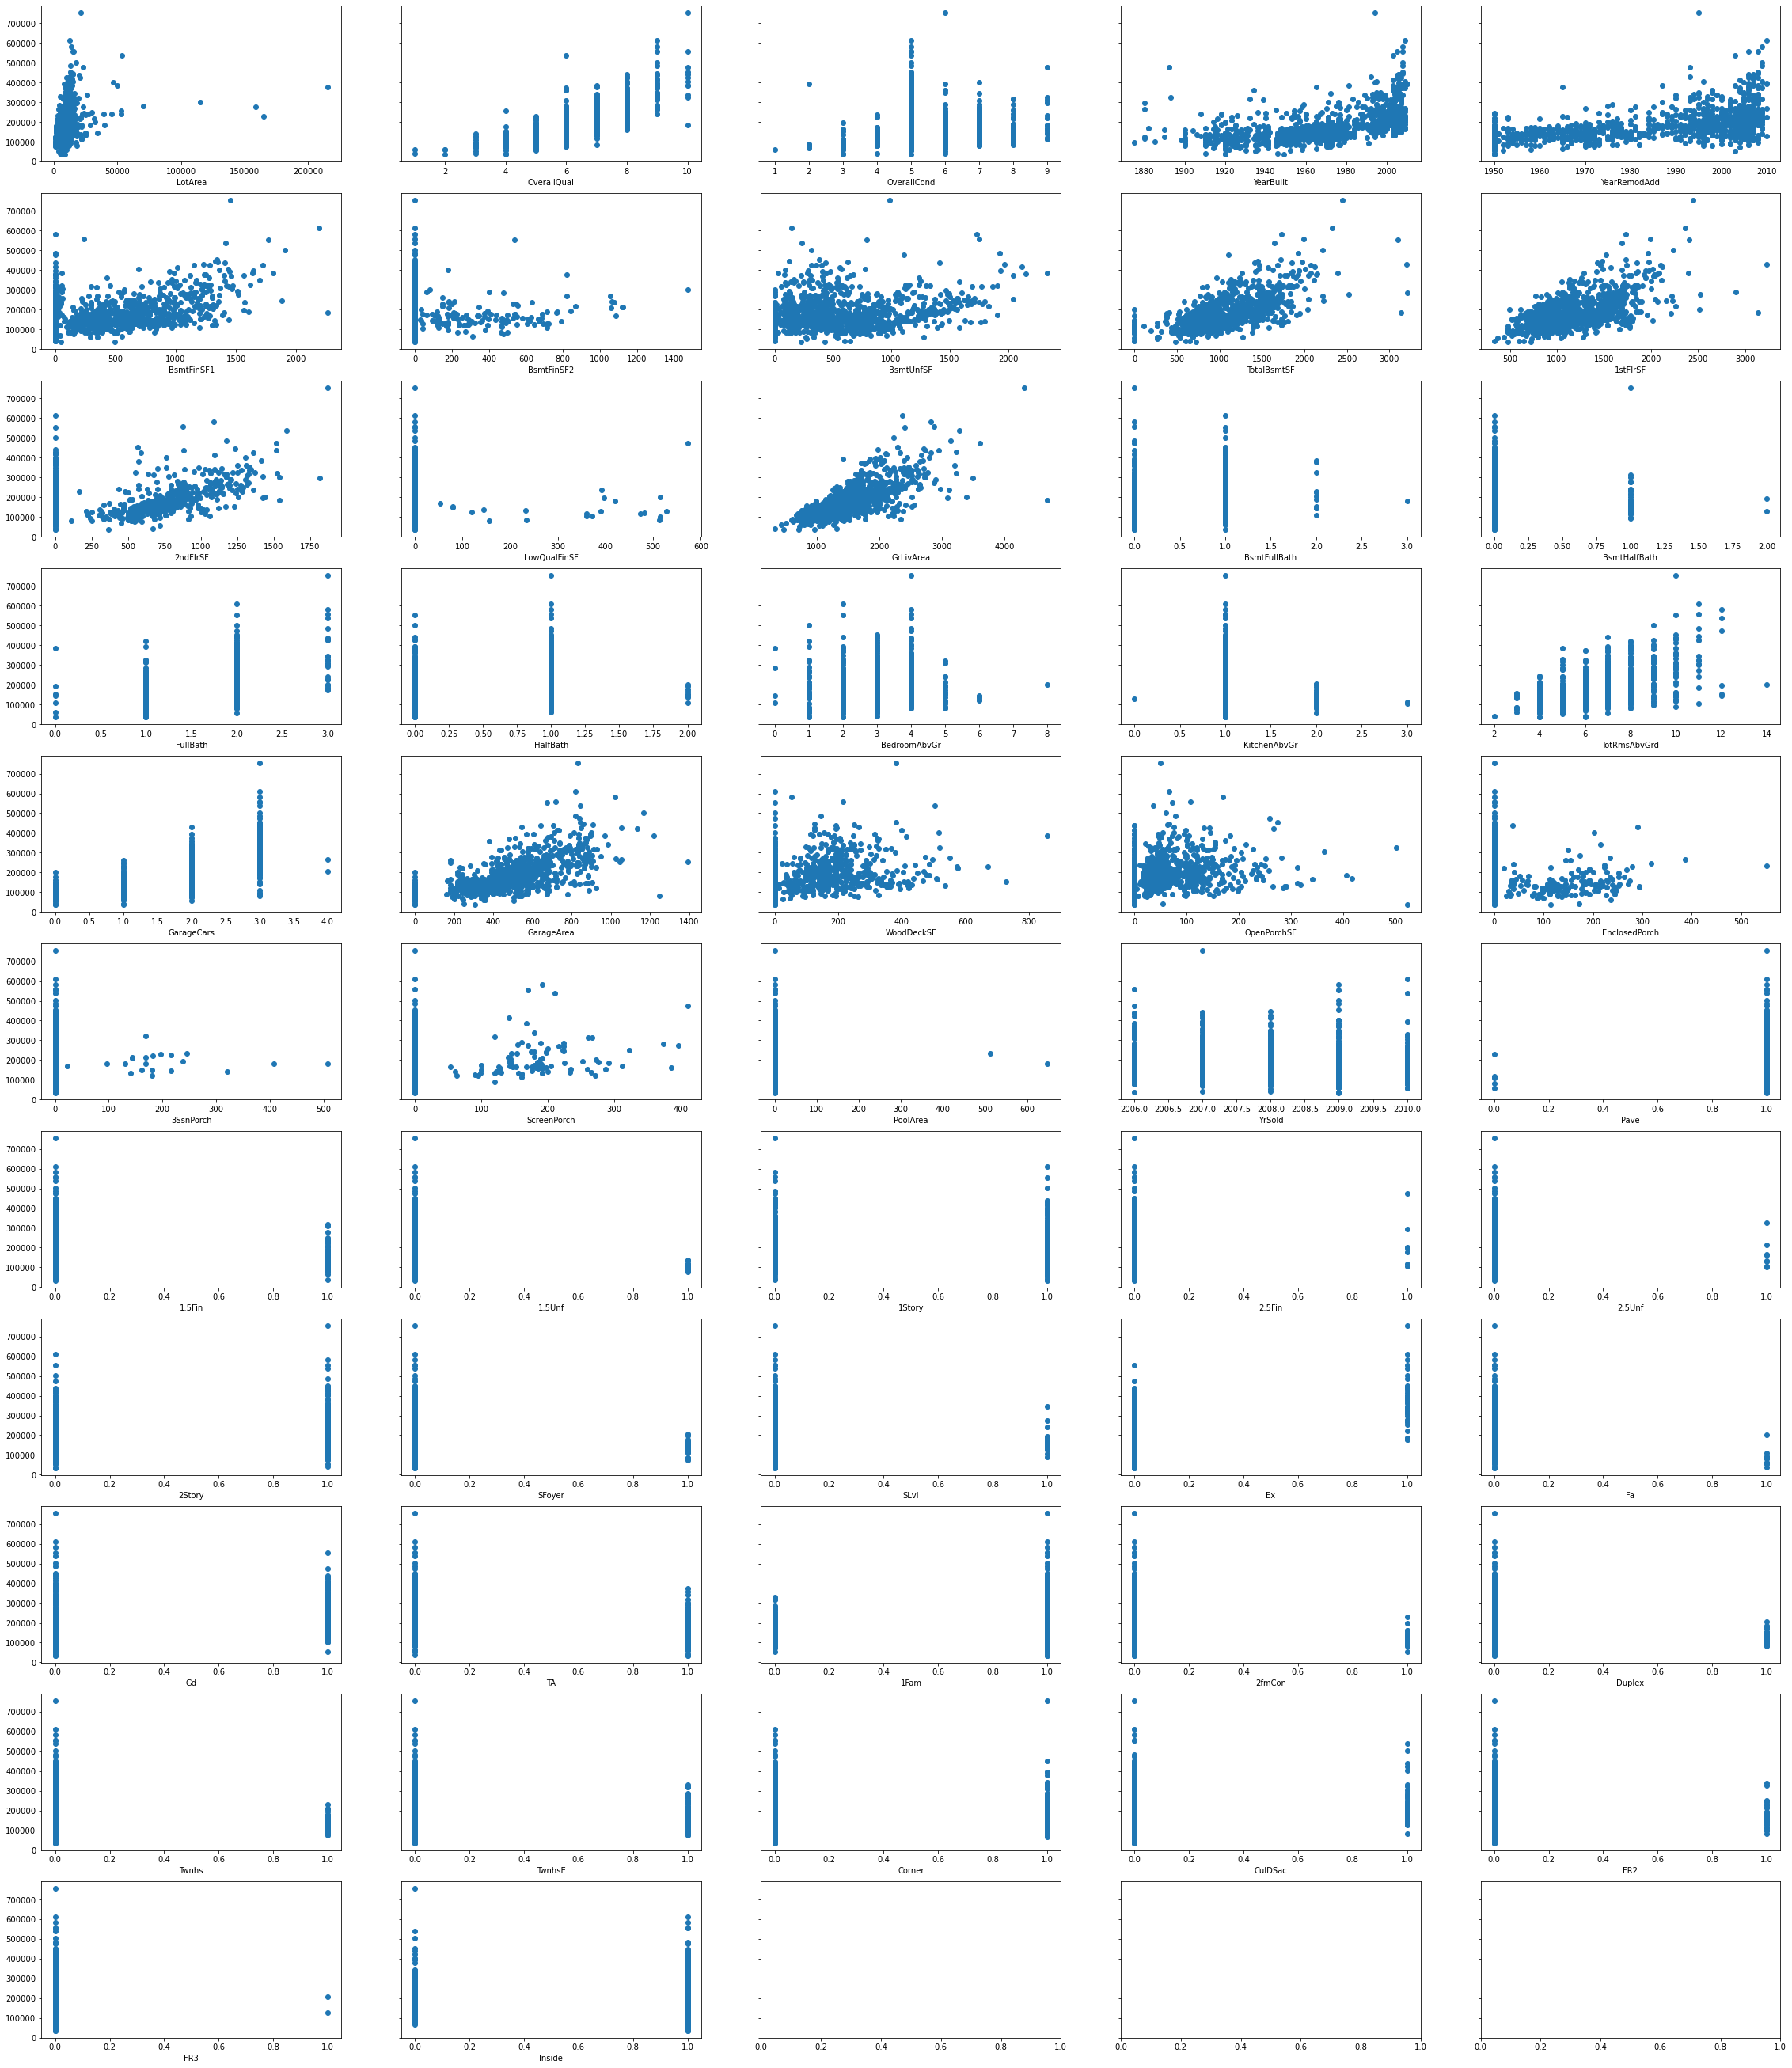

<Figure size 432x288 with 0 Axes>

In [100]:
plot_custom_subplot(X_train_subset, y_train)

In [101]:
run_lin_regression(X_train_subset, y_train, X_test_subset, y_test)


Running ols regression.
Mean squared error: 2284963962.4462194443
Coefficient of determination: 0.6592336999

Running ridge regression.
Mean squared error: 2285073690.6818251610
Coefficient of determination: 0.6592173357

Running huber regression.


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean squared error: 2962673662.1106486320
Coefficient of determination: 0.5581639979

Running ransac regression.
Mean squared error: 2720607175.9508414268
Coefficient of determination: 0.5942643926

Running theil_sen regression.
Mean squared error: 2632726801.6256604195
Coefficient of determination: 0.6073703629


v